In [247]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import time
from scipy.linalg import eigh
from collections import defaultdict

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
import E9_fn.plane_wave_expansion.blochstate_class as bsc
# import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

# Inputs

In [ ]:
species = "Rb87" # "Rb87", "K40"

# lattice parameters
# V1064Er = 5.            # 1064 lattice depth, in 1064 recoil energy
# V532Er = 3.             # 532 lattice depth, in 532 recoil energy
V1064Er = 40.341587 / 2.02781
V532Er = 22.198328 / 8.11125
n0nom = 0               # peak density
# The superlattice phase that determines the relative position between 1064 and 532 lattice
# 532 lattice is fixed at 0, so changing the pase by pi for 1064 restores the original lattice
phi12, phi23 = 0., 0.
# phi12, phi23 = np.pi*1/3, -np.pi*1/3    # decorated triangular lattice
# phi12, phi23 = np.pi*2/3, -np.pi*2/3    # decorated triangular lattice
ABoffset1064nom = 0     # max 0.011585 * V1064nom / 9 / np.sqrt(3) for Rb
B1_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B1
B1_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B1
B3_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B3
B3_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B3

# Basic simulation parameters
num = 6             # size of q-momentum space we consider: (-num, num) (usually 5)
k_center = (0, 0)
bandstart = 0       # starting from 0, inclusive
bandend = 5         # inclusive
Qp_str = '(Kp/K + 0.4 * np.array([np.cos(pi/3), np.sin(pi/3)]))'
qverts_str = 'E9c.Kp4/E9c.k_lw, E9c.Gp/E9c.k_lw, E9c.Kp/E9c.k_lw, E9c.Mp/E9c.k_lw, E9c.Gp/E9c.k_lw'
# qverts_str = 'E9c.Kp/E9c.k_lw, E9c.Kp2/E9c.k_lw, E9c.Kp3/E9c.k_lw, E9c.Kp4/E9c.k_lw, E9c.Kp5/E9c.k_lw, E9c.Kp6/E9c.k_lw, E9c.Kp/E9c.k_lw'
x_ticklist = ["K'", '$\Gamma$', 'K', 'M', '$\Gamma$']
save_results = False

# Initialization
## Units

In [249]:
if species == "Rb87":
    all_units_dict = E9c.all_lat_unit_Rb87
    Er_1064 = E9c.E_r1064_Rb87
    Er_532 = E9c.E_r532_Rb87
elif species == "K40":
    all_units_dict = E9c.all_lat_unit_K40
    Er_1064 = E9c.E_r1064_K40
    Er_532 = E9c.E_r532_K40
else:
    raise ValueError("Unknown species: {}".format(species))
m_unit = all_units_dict["m_unit"]
l_unit = all_units_dict["l_unit"]
E_unit = all_units_dict["E_unit"]
f_unit = all_units_dict["f_unit"]
t_unit = all_units_dict["t_unit"]

V532nom = V532Er * Er_532 / E9c.hnobar / 1e3       # in kHz (i.e. V_SI / hbar / 1e3 / 2pi), assuming that polarizability is accounted for correctly
V1064nom = V1064Er * Er_1064  / E9c.hnobar / 1e3   # Note that setting this to 0 doesn't give you a proper band structure of 532 nm lattice, since you are now
                                # considering too many plane waves that don't actually contribute.
V532 = 2 * np.pi * V532nom * 1e3 / f_unit   # 2 * np.pi because I have f = E/hbar instead of E/h as normally defined
V1064 = 2 * np.pi * V1064nom * 1e3 / f_unit
ABoffset1064 = 2 * np.pi * ABoffset1064nom * 1e3 / f_unit
n0 = n0nom * l_unit**3

In [250]:
Exp_lib = {"species": species, "units_dict": all_units_dict
        , 'V532nom': V532nom, 'V1064nom': V1064nom, 'V532': V532, 'V1064': V1064
        , 'B1_rel_int_532': B1_rel_int_532, 'B1_rel_int_1064': B1_rel_int_1064 , 'B3_rel_int_532': B3_rel_int_532, 'B3_rel_int_1064': B3_rel_int_1064
        , 'n0nom': n0nom, 'n0': n0
        , 'ABoffset1064nom': ABoffset1064nom, 'ABoffset1064': ABoffset1064
        , 'phi12': phi12, 'phi23': phi23}

size = 2 * num + 1
bandnum = bandend - bandstart + 1 # number of bands interested in
qverts_arr = eval(qverts_str)

In [251]:
def MinimumGap(e_values, band1, band2):
    """Prints the position and energy of the minimum gap.
    
    Example: MinimumGap(e_values,2,3)
    Should be slightly enhanced to return something
    """
    gaps = e_values[:, band2] - e_values[:, band1]
    print('The minimum band gap between band{} and band{} is {} kHz, happening at the {} (python index) q evaluated' \
          .format(band1, band2, gaps.min() * f_unit / 1e3 / (2 * np.pi), gaps.argmin()))

def find_q_geo_tensor(n_q, n_band, Exp_lib, q_list, E_list, psi_list, Hq_mmat, Hq_nmat, component = 'xx'):
    """Find the quantum geometric tensor for a given Bloch state psi."""
    q = q_list[n_q]
    psin = psi_list[n_q, :, n_band]
    En = E_list[n_q, n_band]
    dH1 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[0])
    dH2 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[1])
    qgt = 0j
    for m_band in range(E_list.shape[1]):
        if m_band == n_band:
            continue
        psim = psi_list[n_q, :, m_band]
        Em = E_list[n_q, m_band]
        qgt += psim.conj() @ dH1 @ psin * psin.conj() @ dH2 @ psim / (Em - En)**2
    if not util.IsHermitian(qgt):
        logging.warning(f"Quantum geometric tensor for n_band {n_band}, n_q {n_q} is not Hermitian")
    return qgt

# Real space plots

Pretty sure that the orientation is still wrong - maybe flipped about $x = 0$?

In [252]:
bool_plot_real = True
x_real = np.linspace(-1, 1, 500) * 1e-6
y_real = np.linspace(-1.1, 1.1, 500) * 1e-6

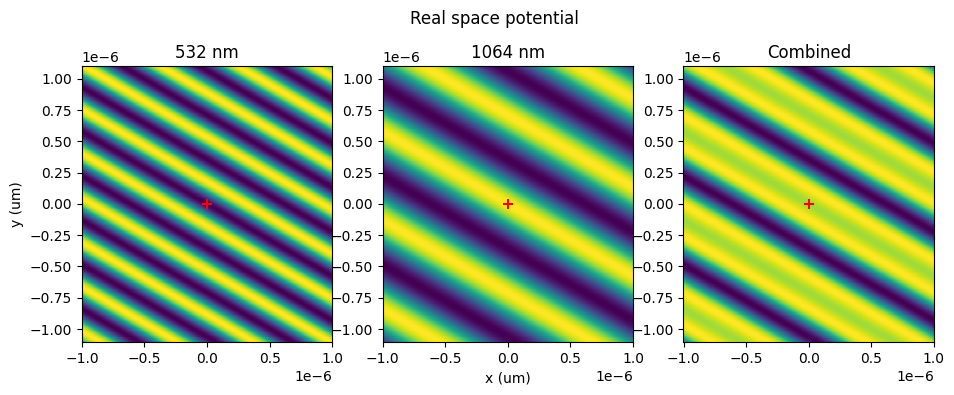

In [253]:
pos_delta = E9c.a_lw_hex * E9c.k1k * (phi12 / 2 / np.pi) + E9c.a_lw_hex * E9c.k3k * (phi23 / 2 / np.pi)
x_delta, y_delta = pos_delta # should be simple functions of phi12 and phi23
V_532_real = bsc.get_Vin(x_real, y_real, V532, B1_rel_int_532, B3_rel_int_532, 0, 0, 1)
V_1064_real = - bsc.get_Vin(x_real, y_real, V1064, B1_rel_int_1064, B3_rel_int_1064, x_delta, y_delta, 2)
V_super_real = V_532_real + V_1064_real
fig_real = plt.figure(figsize = (11, 4))
ax_532 = fig_real.add_subplot(131, aspect = "equal")
ax_1064 = fig_real.add_subplot(132, aspect = "equal")
ax_super = fig_real.add_subplot(133, aspect = "equal")
fig_real.suptitle("Real space potential")
ax_532.set_ylabel("y (um)")
ax_1064.set_xlabel("x (um)")
if bool_plot_real:
    for ax, V_real, ax_title in zip([ax_532, ax_1064, ax_super],
                                    [V_532_real, V_1064_real, V_super_real],
                                    ["532 nm", "1064 nm", "Combined"]):
        im = ax.pcolormesh(x_real, y_real, V_real, cmap = 'viridis')
        ax.scatter(0, 0, color = 'red', marker = '+', s = 50)
        ax.set_title(ax_title)
        # fig_real.colorbar(im, ax = ax)
    

# Finding Bloch states and band energies

Total number of points = 297
--- 2.8854591846466064 seconds ---


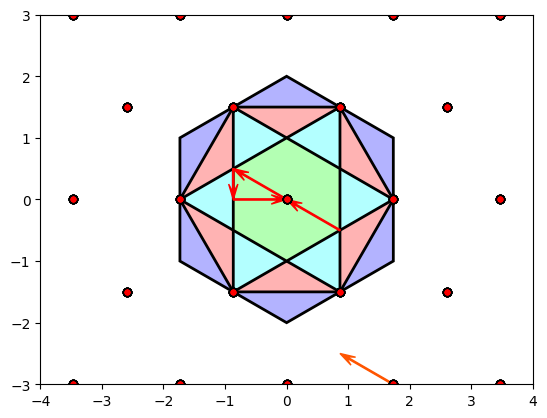

In [254]:
start_time = time.time()

# Generate qset
num_points = np.array([100, 100, 60, 40]) # number of points sampled between two points (can be an array specifying each path, or just one number for all)
index_points = np.hstack((np.array([0]), np.cumsum(num_points))) - np.arange(len(num_points) + 1)
qsets = bsc.FindqSets(num_points, qverts_arr)#bsc.FindqSets(points, Gammap/k, kp/k, mp/k, Gammap/k)
PlotBZinput = qverts_str

e_values = np.zeros((len(qsets), bandnum), dtype = np.cdouble)
e_states = np.zeros((len(qsets), size**2, bandnum), dtype = np.cdouble)
e_states_ni = [[] for _ in range(bandnum)]  # a list of blochstate for each band

# find non-interacting solution
print("Total number of points = {0}".format(len(qsets)))
ax_BZ = bsc.PlotBZSubplot()
bsc.plot_qset(ax_BZ, qset = PlotBZinput)
Hq_mmat, Hq_nmat, H_532, H_1064 = bsc.find_H_components(num, Exp_lib, center = k_center)
for i in range(len(qsets)):
    H = bsc.find_H(qsets[i], Exp_lib, Hq_mmat, Hq_nmat, H_532, H_1064)
    e_values[i,:], e_states[i,:,:] = eigh(H, eigvals = (bandstart, bandend),
                                          overwrite_a = True, check_finite = False)
    for j, bandN in enumerate(range(bandstart, bandend + 1)):
        e_states_ni[j].append(bsc.blochstate(e_states[i,:,j], q = qsets[i], center = k_center, N = bandN, E = e_values[i,j], param = Exp_lib))

print("--- {0} seconds ---".format((time.time() - start_time)))

In [255]:
if not np.all(np.isreal(e_values)):
    logging.warning('Complex eigenvalue detected. Imaginary parts are discarded.')
else:
    e_values = e_values.astype(np.double)

if save_results:
    path_str = "simulation_results\\" #IF NOT WORKING: CHANGE TO FULL PATH NAME // TRY ADDING FULL PATH TO "PYTHONPATH manager"
    suffix_str = "_honeycomb_NearG_20210826"
    sim_str = "e_values_ni_{0}_{1}_{2}_k{3}{3}_{4}{5}".format(
                V532nom, V1064nom, n0nom, num, k_center[0], k_center[1])
    bsc.SaveStateList(path_str + sim_str + suffix_str, e_states_ni)

C:\Users\ken92\AppData\Local\Temp\ipykernel_18680\3268161843.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  e_values = e_values.astype(np.double)


# Plots

## Band structure

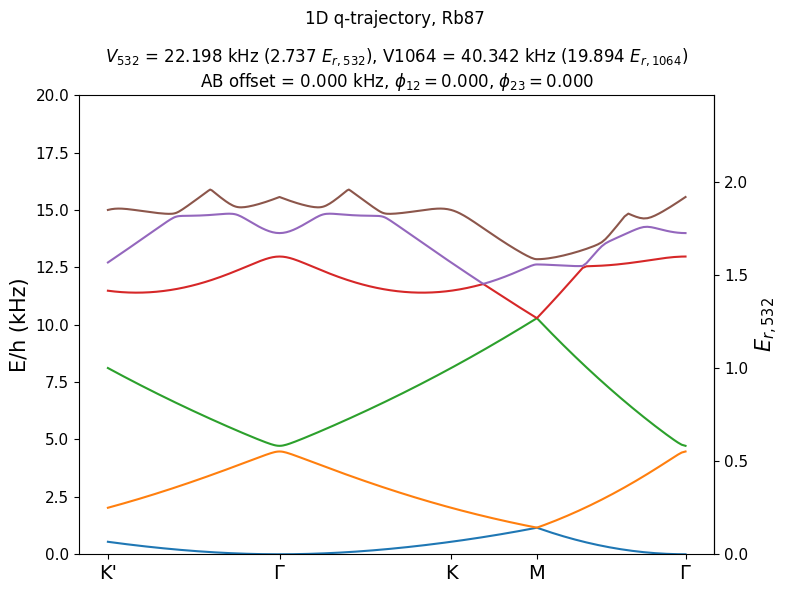

In [256]:
f2kHz = f_unit / 1e3 / (2 * np.pi) # conversion factor from natural units to kHz
E_lowest = np.min(e_values)
E_kHz_offset = (e_values - E_lowest) * f2kHz
E_kHz_highest = np.max(E_kHz_offset)
fig_E = plt.figure(0, figsize=(8,6))
fig_E.clf()

ax_E = fig_E.add_subplot(111)
xq = bsc.FindQAxis(num_points, qverts_arr)
for i in range(bandnum):
    E_plot_kHz = (e_values.transpose()[i] - E_lowest) * f2kHz
    ax_E.plot(xq, E_plot_kHz, '-', label = 'Non-interacting' + str(i + bandstart))
ryax = ax_E.secondary_yaxis('right', functions = (lambda x: x / (f2kHz * 2 * np.pi**2), lambda x: x * (f2kHz * 2 * np.pi**2)))
ryax.set_ylabel(r"$E_{r,532}$", fontsize = 15)
ryax.tick_params(axis = 'y', labelsize = 11)
ax_E.set_ylabel('E/h (kHz)', fontsize = 15)
ax_E.set_xticks(xq[index_points], x_ticklist, fontsize = 14)
ax_E.tick_params(axis = 'y', labelsize = 11)
ax_E.set_title((rf'$V_{{532}}$ = {V532nom:.3f} kHz (${V532Er:.3f}\ E_{{r, 532}}$), V1064 = {V1064nom:.3f} kHz (${V1064Er:.3f}\ E_{{r, 1064}}$)'
                '\n'
                rf'AB offset = {float(ABoffset1064nom):.3f} kHz, $\phi_{{12}} = {phi12:.3f}$, $\phi_{{23}} = {phi23:.3f}$'))
ax_E.set_ylim(0, 20)

fig_E.suptitle(f'1D q-trajectory, {species}')
fig_E.tight_layout()

## Bloch state
### Population in each peak
I use the ground state to visualize the peak that I'm looking at.

In [257]:
color_B12 = np.array([1, 0, 0])      # Colors in an array of [R, G, B] for easier numerical manipulation
color_B23 = np.array([0, 1, 0])
color_B13 = np.array([0, 0, 1])
color_center = np.array([0, 0, 0])
# This is arranged in the order of [G1, G2, G3]
all_colors = np.vstack([color_B23, color_B13, color_B12])

dict_diff_order = {
    "G1_1st": np.array([1, 0, 0]),
    "G2_1st": np.array([0, 1, 0]),
    "G3_1st": np.array([0, 0, 1]),
    "G1_2nd": np.array([2, 0, 0]),
    "G2_2nd": np.array([0, 2, 0]),
    "G3_2nd": np.array([0, 0, 2]),
    "G1_G2": np.array([1, -1, 0]),  # This is G1_1st - G2_1st; other pairs follows similarly
    "G2_G3": np.array([0, 1, -1]),
    "G3_G1": np.array([-1, 0, 1]),
}

hw_mn = (E9c.k_lw * 0.3, E9c.k_lw * 0.3)    # half width of the box that encloses each peak

0.9984266881773318


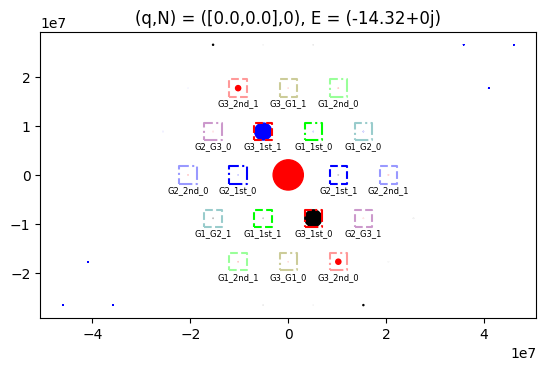

In [258]:
psi_gs = e_states_ni[0][99] # Need to fix this ugly code at some point
dict_pop_in_pairs = defaultdict(float)
dict_pop_diff_in_pairs = defaultdict(float)
ax_gs = bsc.ToFSubplot(psi_gs)

for label_pair, diff_order in dict_diff_order.items():
    num_of_diff = abs(diff_order).sum()
    color = abs(diff_order) @ all_colors / num_of_diff
    alpha = 1 - np.sqrt(num_of_diff - 1) * 0.6
    for i_pk, ls_pk in zip([0, 1], ["-.", "--"]):
        m_diff = diff_order[0] - diff_order[2]
        n_diff = diff_order[1] - diff_order[2]
        vec = ((m_diff + psi_gs.q[0]) * E9c.G1 +
               (n_diff + psi_gs.q[1]) * E9c.G2) * (-1)**i_pk
        util.plot_rectangle(ax_gs, center = vec, half_widths = hw_mn,
                            color = color, alpha = alpha, ls = ls_pk)
        ax_gs.text(vec[0], vec[1] - E9c.k_lw * 0.6, label_pair + f'_{i_pk}',
                   fontsize = 6, horizontalalignment = 'center', color = 'k')
        dict_pop_in_pairs[label_pair] += abs(psi_gs.mnasindex(m_diff, n_diff))**2
        dict_pop_diff_in_pairs[label_pair] += abs(psi_gs.mnasindex(m_diff, n_diff))**2 * (-1)**i_pk

# Total population within peaks less than second order diffraction
print(sum([v for v in dict_pop_in_pairs.values()]) + abs(psi_gs.mnasindex(0, 0))**2)

### Visualize a particular Bloch state

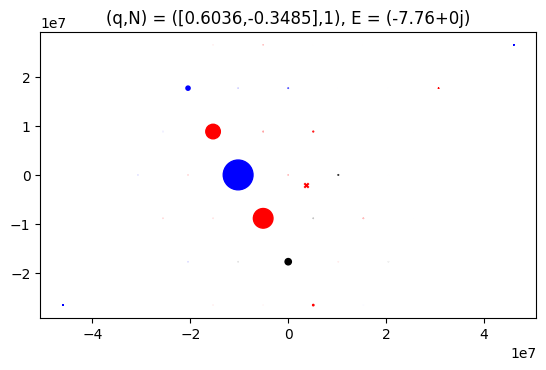

In [259]:
# ax_ToF = bsc.ToFSubplot(bsc.FindInStateList(e_states_ni[1], E9c.Kp*0.5, 1))
ax_ToF = bsc.ToFSubplot(e_states_ni[1][30])

## Quantum metric tensor

In [260]:
bool_find_QMT = False

In [261]:
if bool_find_QMT:
    qgts_xx = np.zeros((len(qsets), bandnum), dtype = np.cdouble)
    for i in range(len(qsets)):
        for j in range(bandnum):
            qgts_xx[i, j] = find_q_geo_tensor(i, j, Exp_lib, qsets, e_values, e_states, Hq_mmat, Hq_nmat)
    qmts_xx = np.real(qgts_xx)                # quantum metric tensor
    berry_curvs_xx = - 2 * np.imag(qgts_xx)   # Berry curvature

    fig_qgt = plt.figure(2, figsize=(10,7))
    fig_qgt.clf()
    ax_qgt = fig_qgt.add_subplot(111)
    ax_qgt.set_title('Quantum geometric tensor')
    ax_qgt.plot(xq, qmts_xx[:, 2], label = 'qmts_00')